## 1.1 Цель
Предсказать качество вина по составу

## 1.2 Описание
Вино - это продукт питания, то есть вещество, предназначенное для еды и содержащее питательные макро - и микровещества, способные обеспечить нужды человеческого организма. В свете такого определения вино, без сомнения, является продуктом питания, потому, что оно содержит питательные макро вещества (углеводы, некоторые протеиды), обеспечивающие организм энергией, и особенно микровещества.


[Описание от Kaggle](https://www.kaggle.com/rajyellow46/wine-quality?select=winequalityN.csv)

## 2.2 Вспомогательные функции

In [220]:
def plot_correlation_map( df ):
    corr = data.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
    
def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def get_value(X, column, mode='mean', value=0, columns_for_reg=None):
  if mode == 'value':
    X.loc[X[X[column].isna()].index ,column] = value
  elif mode == 'max':
    X.loc[X[X[column].isna()].index ,column] = X[column].max()
  elif mode == 'min':
    X.loc[X[X[column].isna()].index ,column] = X[column].min()
  elif mode == 'median':
    X.loc[X[X[column].isna()].index ,column] = X[column].median()    
  elif mode == 'mode':
    X.loc[X[X[column].isna()].index, column] = X[column].mode()[0]  
  elif mode == 'indicator':
    X.loc[X[X[column].isna()].index, column] = 0
    X['ind_'+str(column)] = 0
    X.loc[X[X[column].isna()].index, 'ind_'+str(column)] = 1
  elif mode == 'linreg':
    if columns_for_reg is None:
      cols = list(X.select_dtypes([np.number]).columns) 
      cols.remove(column)
    else:
      cols = columns_for_reg
    X_tmp = X.dropna()  
    m = LinearRegression().fit(X_tmp[cols], X_tmp[column])
    X.loc[X[X[column].isna()].index, column] = m.predict(X[X[column].isna()][cols])
  else:
    X.loc[X[X[column].isna()].index, column] = X[column].mean()
  return X  


# 2. Data Understanding

## 2.1 Import Libraries

In [221]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.linear_model import LinearRegression

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Загрузка данных

In [240]:
data = pd.read_csv("/Users/gost1/Desktop/Новая папка/winequalityN.csv")

## 2.3 Статистика и визуализации
Проверем данные на наличие пропусков

In [223]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [224]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# **Описание переменных**

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- quality (score between 0 and 10)

### 2.4 Взглянем на некоторую ключевую информацию о переменных

In [225]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Посмотрим тепловую карту корреляции

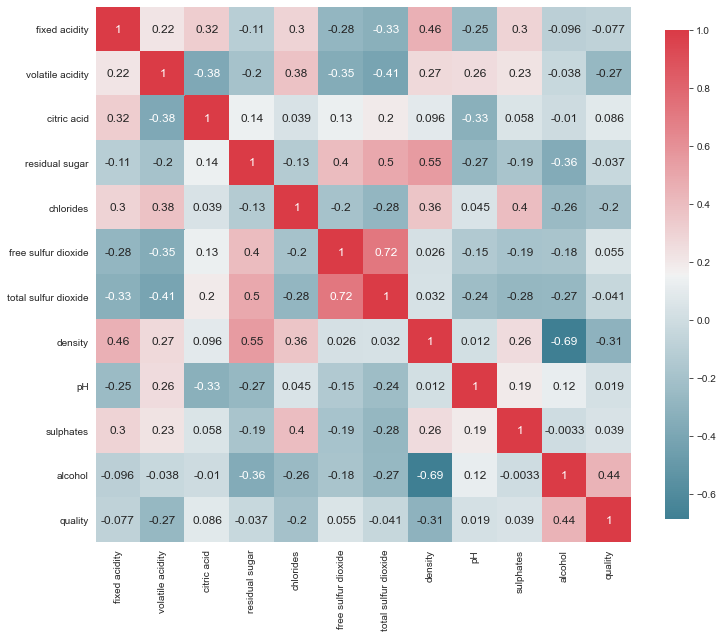

In [226]:
plot_correlation_map( data )

### 2.5 Вид вина
Мы можем посмотреть на категориальные переменные, такие как type и их связь с качеством

- Белое   
- Красное

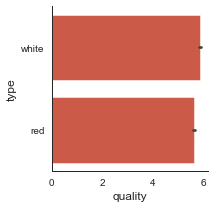

In [227]:
plot_categories( data , cat = 'quality' , target = 'type' )

# 3. Data Preparation

# 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

Переменная type рассматривается как категориальная переменная. Используем OneHotEncoding.

In [228]:
one_hot = pd.get_dummies(data['type'])
data = data.drop('type',axis = 1)
data = data.join(one_hot)
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,white
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,0,1
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,0,1
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,0,1
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0,1
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1,0
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6,1,0
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1,0
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1,0


## 3.2 Заполнить пропущенные значения в переменных
Заполним пропуски. В столбец fixed acidity заполним пропущенные данный модой, в остальных столбцах заполним пропущенный данные при помощи линейной регрессии

In [229]:
_ = get_value(data, 'fixed acidity', mode='mode', value='other')
_ = get_value(data, 'volatile acidity', mode='linreg', value='other')
_ = get_value(data, 'citric acid', mode='linreg', value='other')
_ = get_value(data, 'residual sugar', mode='linreg', value='other')
_ = get_value(data, 'chlorides', mode='linreg', value='other')
_ = get_value(data, 'pH', mode='linreg', value='other')
_ = get_value(data, 'sulphates', mode='linreg', value='other')

### Проверем, что пропуски в данных отсутствуют 

In [230]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  red                   6497 non-null   uint8  
 13  white                 6497 non-null   uint8  
dtypes: float64(11), int64(1), uint8(2)
memory usage: 621.9 KB


## 3.3 Сборка финальных датасетов для моделирования

In [233]:
Y = data.quality

In [234]:
X = data
X = X.drop('quality',axis = 1)

In [235]:
train_X , valid_X , train_y , valid_y = train_test_split( X , Y , train_size = .7 )

# 4. Моделирование
Выбираем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
Возьмем случайный лес.

In [237]:
model = RandomForestClassifier(max_depth=10 , random_state=0)

## 4.2 Обучение модели

In [238]:
model.fit(train_X , train_y)

RandomForestClassifier(max_depth=10, random_state=0)

# 5. Оценка
Теперь оценим модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [239]:
# Score the model
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.822740268308775 0.642051282051282
